#Number recognition project

The purpose of this project is to use PyTorch to create a Conventional Neural Network (CNN) model to identify the number written in an image. The model would be created using a Modified National Institute of Standards (MNIST) dataset containing images with numbers 0 to 9 written on them. Lastly, to test the model further I will use images I made myself using a Windows application called Paint  to see if the model can correctly identify the numbers given.

## Import

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from PIL import Image

##Data preparation


This section of code obtains the numbered MNIST dataset and preprocesses it so it is ready to be used for the neural network task.

In [2]:
# create data transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# download datasets
mnist_train = datasets.MNIST(
    root='/content',
    train=True,
    download=True,
    transform=transform
)

mnist_test = datasets.MNIST(
    root='/content/',
    train=False,
    download=True,
    transform=transform
)

# create dataLoaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True,num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False,num_workers=4, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.44MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
len(mnist_train.classes)# classes are numbers 0-9

10

In [4]:
# get one batch
images, labels = next(iter(train_loader))

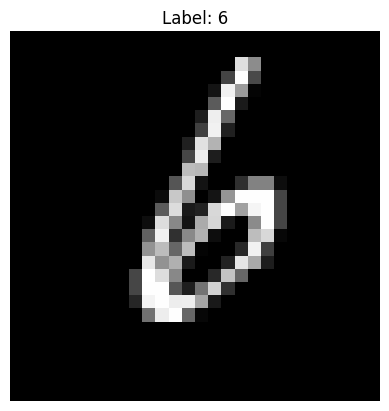

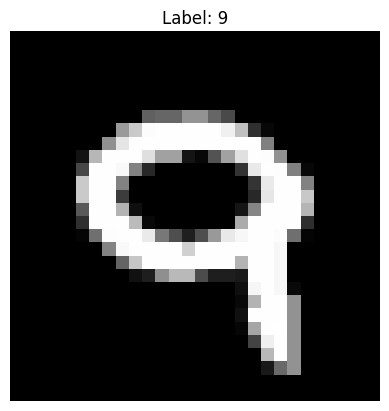

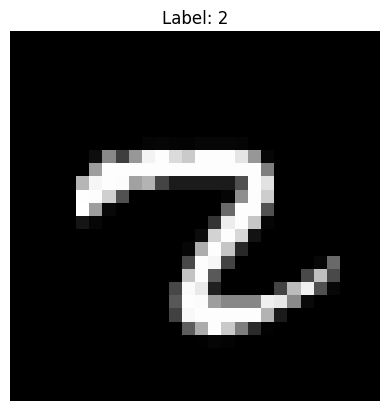

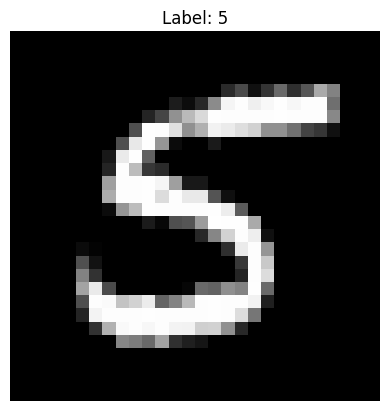

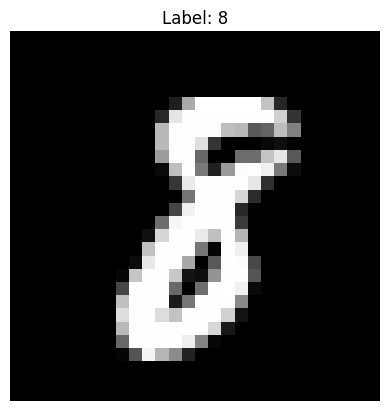

In [5]:
# view first 5 images in batch
for i in range(0,5):
  plt.imshow(images[i].squeeze(), cmap='gray')
  plt.title(f"Label: {labels[i].item()}")
  plt.axis('off')
  plt.show()

In [6]:
print(images.shape)

torch.Size([64, 1, 28, 28])


## Model creation



In creating the CNN model, the first thing made is the feature extraction layers. These layers are to extract important features/patterns from the input image.
Next, it then uses these in the fully connected layers to identify the number in the image.

In [7]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_size=(28, 28)):
        super().__init__()


        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),#layers to extract features
            nn.BatchNorm2d(32),#accelerates training & improves stability
            nn.ReLU(),# add non-linearity
            nn.MaxPool2d(kernel_size=2),#reduce dimensionality

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self._to_linear = self._get_flattened_size(input_size)

        # fully connected (fc) layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.Dropout(0.3),# prevents overfitting
            nn.Linear(256, 10)
        )

    # compute flattened feature size for FC layer instead of manually calculating it
    def _get_flattened_size(self, input_size):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_size)  # batch size = 1
            out = self.features(dummy)
            return out.view(1, -1).shape[1]  # return flattened feature size

    #forward pass of model (how it runs)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x



## Model training

The model would be trained for up to 10 epochs (how many times it goes through the training data). I am tracking the accuracy as well as the training and validation loss of each epoch. Loss measures how far off the model’s predictions are from the actual target values. Accuracy is the percentage of correct predictions out of total predictions. <br><br>
The training process will stop if there is no improvement in its accuracy after 3 epochs in a row.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# use gpu instead of cpu for processing
model = CNN().to(device)# create cnn model

In [9]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# optimizer (Adam) for model parameter updates
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=1)# reduces learning rate if validation accuracy plateaus
criterion = nn.CrossEntropyLoss()# loss function for multi-class classification

In [10]:

n_epochs = 10
epochs_without_improvement = 0
patience = 3 # stop after this many epochs without improvement
# training metrics
best_accuracy = 0.0
cost_list = []# stores training loss per epoch
accuracy_list = []  # stores validation accuracy per epoch

for epoch in range(n_epochs):
    model.train() # set model to training mode
    running_loss = 0.0

    #train model
    for x, y in train_loader:# iterate over mini-batches from training data
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)#move data to gpu/cpu

        optimizer.zero_grad(set_to_none=True)#reset gradients before backward pass

        outputs = model(x)# forward pass: compute model outputs
        loss = criterion(outputs, y)# compute loss between outputs and ground truth

        loss.backward()# backward pass: compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)#clip gradients to prevent exploding gradients
        optimizer.step()# update model parameters

        running_loss += loss.item()


    model.eval()# set model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0

    # validate model
    with torch.no_grad():#prevent gradient calulation
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)#move validation data to device
            outputs = model(x_test)# forward pass
            loss = criterion(outputs, y_test)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

    # calculate average training and validation loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(test_loader)

    accuracy = correct / total

    scheduler.step(accuracy)
    #save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        #end training early if no improvement after 3 epochs in a row
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    cost_list.append(epoch_loss)
    accuracy_list.append(accuracy)

    print(f'Epoch [{epoch+1}/{n_epochs}]')
    print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f}')

Epoch [1/10]
Train Loss: 0.1194 | Val Loss: 0.0416 | Accuracy: 0.9874
Epoch [2/10]
Train Loss: 0.0460 | Val Loss: 0.0377 | Accuracy: 0.9868
Epoch [3/10]
Train Loss: 0.0347 | Val Loss: 0.0247 | Accuracy: 0.9917
Epoch [4/10]
Train Loss: 0.0253 | Val Loss: 0.0294 | Accuracy: 0.9903
Epoch [5/10]
Train Loss: 0.0202 | Val Loss: 0.0220 | Accuracy: 0.9930
Epoch [6/10]
Train Loss: 0.0175 | Val Loss: 0.0226 | Accuracy: 0.9938
Epoch [7/10]
Train Loss: 0.0154 | Val Loss: 0.0260 | Accuracy: 0.9932
Epoch [8/10]
Train Loss: 0.0122 | Val Loss: 0.0260 | Accuracy: 0.9932
Epoch [9/10]
Train Loss: 0.0037 | Val Loss: 0.0196 | Accuracy: 0.9947
Epoch [10/10]
Train Loss: 0.0024 | Val Loss: 0.0205 | Accuracy: 0.9951


### Training results

These results are ideal as it shows that after more epochs the accuracy increases and the cost (average training loss per epoch) decreases. This means that the model should perform well in its task.

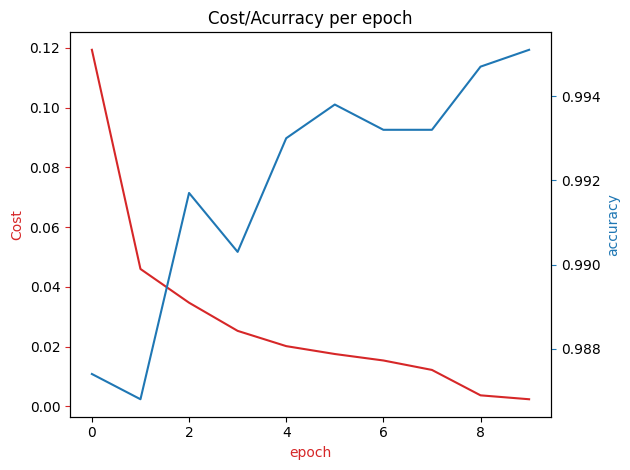

In [11]:
fig, ax1 = plt.subplots()
#plot cost
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

#plot accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
plt.title('Cost/Acurracy per epoch')
fig.tight_layout()

## Test Paint images

To further test the model, I have written used the Paint application to create three images with numbers 1,5 and 7 written on them. In order to apply the model to classify them, they must first be preprocessed to match the format of the MNIST dataset numbers.<br><br>
In the results, you will see the:
* The preprocessed image (what the model sees)
* Then the original image and what the model classified it as

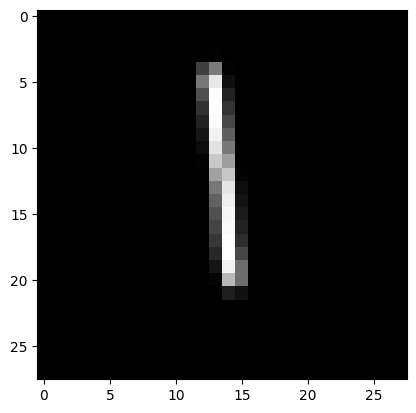

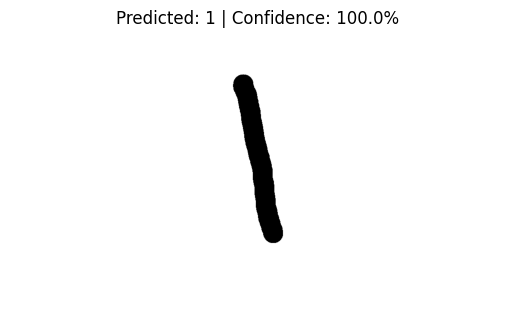

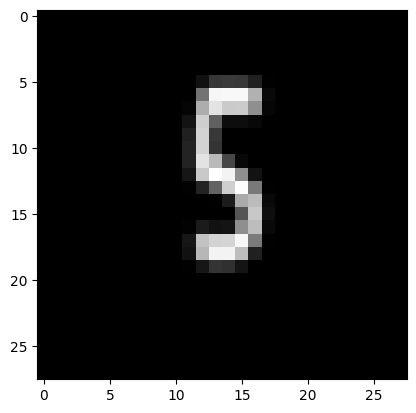

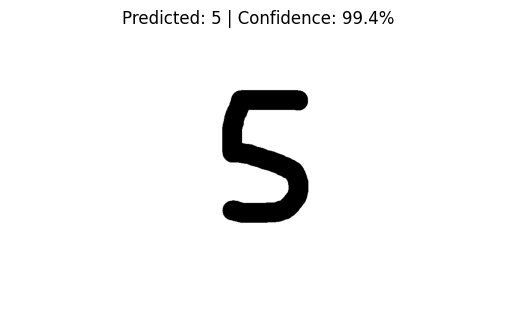

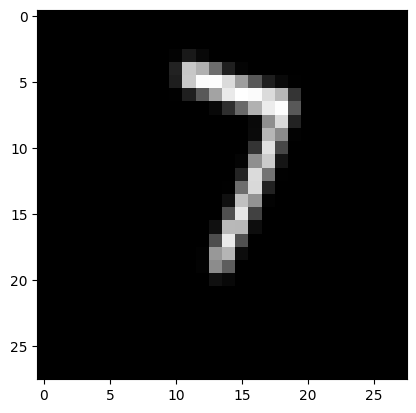

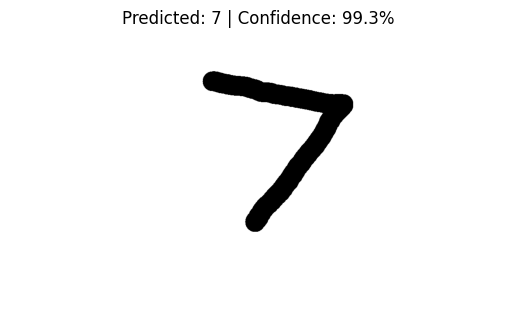

In [13]:
# load best trained model
best_model = CNN()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()  # set to evaluation mode not training

#new transform so new data matches format of train/test data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.functional.invert,
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def predict_digit(image_path):
    # load and preprocess image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # add batch dimension
    plt.imshow(image.squeeze(), cmap='gray')#show new preprocessed image
    plt.show()

    # prediction
    with torch.no_grad():
        output = best_model(image)
        _, predicted = torch.max(output, 1)
        probabilities = torch.nn.functional.softmax(output, dim=1)

    return predicted.item(), probabilities.squeeze().tolist()

# Example usage
image_paths = ["/content/num 1.png", "/content/num 5.png", "/content/num 7.png"]

for path in image_paths:
    prediction, probs = predict_digit(path)
    plt.imshow(Image.open(path), cmap='gray')#show original image
    plt.title(f"Predicted: {prediction} | Confidence: {probs[prediction]*100:.1f}%")
    plt.axis('off')
    plt.show()


## Conclusion


In conclusion, the project is a success as I have created a CNN model that can accurately classify number images. However, this project overall can be improved further if I were to attempt it again by:

* Adding the model to a webpage where users can draw a number on screen and the program will use the model to attempt to classify the number
* Training the model to be able to predict numbers outside the range 0-9